# Project 2: Laplacian pyramid blending &amp; hybrid images

Due Friday, March 4 at 11:59pm

## 1. Background

In this project, you will investigate two applications:
*Laplacian pyramid blending* and *hybrid images*.  You can
use the former to make smooth transitions between arbitrary images,
such as the apple/orange blend depicted here:

<p align="center">
  <img src="description-images/apple_orange.jpg" width="30%" />
</p>

The hallmark of the Laplacian pyramid blend is that low-frequency
features (like the constant green or orange hues of the fruits) are
blended over larger distances than high-frequency features (such as
the tiny dots on the apple or the dimples on the orange).

Hybrid images are interesting optical illusions, as we saw in class and as described in
the section below.

Knowing how image features are distributed across the frequency
spectrum is critical for understanding both of these applications.

### 1.1 Laplacian operator

Similar to the gradient, the *Laplacian operator* is a derivative of a
scalar function such as a grayscale image. Whereas the gradient is a
first derivative that maps an image to a vector at each point, the
Laplacian is a second derivative that maps an image to a scalar at
each point.

The definition of the Laplacian of a function $f: \mathbb{R}^2 \mapsto \mathbb{R}$ is given by
$$
\nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}.
$$
That is, the Laplacian is the sum of second partial derivatives of the image.

Just as the partial derivative of a blurred image can be computed by
filtering with the derivative of a Gaussian, the Laplacian of a
blurred image can be computed by filtering with the Laplacian of a
Gaussian (LoG) filter, defined as the Laplacian of the Gaussian
kernel.

Here is the LoG kernel in 1D and 2D:

<p align="center">
  <img src="description-images/LoG.png" width="50%" />
</p>
  
As it turns out, the LoG filter can be well-approximated by a
difference of Gaussians (DoG).  On the left below are two Gaussians
$g_1$ and $g_2$ whose widths are given by $\sigma_1$ and $\sigma_2 = 2
\sigma_1$; on the right is a similarly-scaled LoG filter.

<p align="center">
  <img src="description-images/DoG.png" width="50%" />
</p>

As you can see, the difference $g_2 - g_1$ closely approximates the
LoG kernel (and the same holds for 2D Gaussians/LoG kernels as well).

Hence, by linearity of filtering, taking the difference of two blurs of the same image
is approximately the same as filtering with the LoG:
\[
(I * g_2) - (I * g_1) = I * (g_2 - g_1) \approx I * LoG.
\]
The equation above forms the basis of the so-called *Laplacian
  pyramid* (see section 3.5.3 of the Szeliski textbook), which encodes
an image as a succession of progressively smaller Laplacian-filtered images.
The coarsest layer of the image consists of a blurred and reduced copy of the original image.


### 1.2 Alpha blending


An *alpha mask* is a special type of single-channel image where every pixel
represents a coefficient for a weighted average of two RGB input images.

In the grid below, the top row represents two input RGB images.  The
bottom-left image is a continous mask where 0 corresponds to pixels
from the left input, 1 corresponds to pixels from the right image, and
any value in between corresponds to some combination of the respective
pixels from each image.  The bottom-right image is the *alpha blend* result.

<p align="center">
  <img src="description-images/apple_orange_alpha_blending.png" width="60%" />
</p>

Assuming a floating-point mask, code for an alpha blend might look
something like this:

~~~ Python
for y in range(height):
  for x in range(width):
    for channel in range(3):
       result[y,x,c] = img1[y,x,c] * (1.0 - mask[y,x]) + img2[y,x,c] * mask[y,x]
~~~

This algorithm is implemented much more efficiently as `project2_util.alpha_blend`.

The main advantage of alpha blending over strictly boolean masks is
that you can achieve smoother transitions between regions by combining
image pixels continuously.

See <https://en.wikipedia.org/wiki/Alpha_compositing> or Szeliski
section 3.1.3 for more details.

### Before You Go On

Before you go on, look over the **`examples.ipynb`** file from run through the example commands you find there.

## 2. Laplacian pyramid blending

The Laplacian pyramid is a useful data structure for understanding
images at multiple scales.  Here is a Laplacian pyramid of a cat
(source image at `/work/description-images/blep.jpg`):

  ![](description-images/blep_lp.jpg)
 
As you can see, the images are decreasing in size, and all but
the smallest/coarsest are derivative images (i.e. their intensity
values can be either positive or negative, with middle gray
representing zero intensity).

### 2.1 Create a Laplacian pyramid

Given an input image $I$, we can construct a Laplacian pyramid $P =
(L_0, L_1, L_2, \ldots, L_N)$ of depth $N+1$ according to the
following rules:

  * Define $G_0$ to be the input image itself, so $G_0 = I$.

  * For each $i$, if the $G_i$ image is large enough (e.g. both height
    and width are at least 16 pixels), we obtain $L_i$ as follows:

    * First obtain $G_{i+1}$ by calling [`cv2.pyrDown`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gaf9bba239dfca11654cb7f50f889fc2ff) with
      $G_i$ as input. This convolves $G_i$ with a small Gaussian kernel
      and then discards the odd-numbered rows and columns of the image,
      resulting in a half-size image.
    
    * Next obtain $G_{i+1}^{\uparrow}$ by calling
      [`cv2.pyrUp`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gada75b59bdaaca411ed6fee10085eb784)
      with $G_{i+1}$ as input, taking care to also provide `cv2.pyrUp`
      with the size of the original $G_i$ image. This function enlarges
      $G_{i+1}$ to be the same size as $G_i$. 
      
    * Finally, obtain $L_i = G_i - G_{i+1}^\uparrow$. Make sure
      to cast both images to `numpy.float32` before subtracting,
      otherwise you will have errors due to overflow.
      
  * Otherwise, if $G_i$ is small (e.g. either height or width is less
    than 16 pixels), we decide that $i = N$ and set $L_N = G_N$ (but
    make sure to cast to `numpy.float32` so that all of your `L_N`
    images are floating-point).

Modify the **`laplacian_blend`** function in your repository to
implement a function `pyr_build(img)` which takes an image of datatype
`numpy.uint8` as input, and which outputs a list `lp` of Laplacian
images stored in `numpy.float32` format. You can test it on the first
image passed into the **`laplacian_blend`** function arguments.

You can display your pyramid using the
`project2_util.visualize_pyramid` function. Just pass in the output
from your `pyr_build` function and it will return a regular
`numpy.uint8` image you can save or display.

I suggest you test your pyramid function by building a pyramid of
this cat (in `description-images/blep.jpg`) to a depth of $N = 3$ and visually verifying
that it matches the example pyramid above.

<p align="center"><img src="description-images/blep.jpg" width="40%"/></p>

Once you've verified that it's working for a small pyramid, you can
continue iterating until you reach an appropriate maximum depth with
the coarsest image being less than 16 pixels on its smallest side.

### 2.2 Reconstruct an image from a pyramid

Converting a source image to a Laplacian pyramid is a (nearly)
invertible transformation, up to round-off error due to data-type
conversions.

Here's how to convert back from a Laplacian pyramid $P = (L_0, \ldots
L_N)$ to an image $I$:

  * Define the reconstructed image $R_N = L_N$.
  
  * Define the reconstructed image $R_{i-1} = R_{i}^\uparrow +
    L_{i-1}$, where $R_{i}^\uparrow$ is obtained by calling
    `cv2.pyrUp` with $R_{i}$ as input. Don't forget to pass the size
    of $L_{i-1}$ to `cv2.pyrUp` as well.
    
  * When you reach $R_0$, the result should be nearly identical to the
    original image $I$ from which the pyramid was created.
    

Say that `recons` is a numpy array corresponding to one of your $R_i$
floating-point images from the reconstruction algorithm outlined
above.  To mitigate the effects of any numerical errors, you should
clip its intensity values to the $[0, 255]$ range before converting it
back to `numpy.uint8`. The suitable Python code to accomplish this
would be:

~~~ Python
recons_u8 = np.clip(recons, 0, 255).astype(np.uint8)
~~~

Update your **`laplacian_blend`** by implementing a function
`pyr_reconstruct(lp)` that takes a Laplacian pyramid (list of
floating-point images) as input, and which returns a `numpy.uint8`
image.

Try reconstructing the first source image named on the command line
from the pyramid you constructed in the previous step, and make sure
it is visually indistinguishable from the original before continuing.

## Combine two Laplacian pyramids

Assume we have two RGB images `imgA` and `imgB` and a single-channel
`mask`, all of the same dimensions.

We can implement the Laplacian pyramid blend of `imgA` and `imgB` by
the given `mask` by following these steps:

  * Construct the Laplacian pyramids `lpA` and `lpB` corresponding to
    each input image.
   
  * For each pyramid level `i`, obtain a new Laplacian image by 
    alpha-blending the pair `lpA[i], lpB[i]` with a resized mask:
    
    ~~~ Python
    h, w = lpA[i].shape[:2]
    mask_i = cv2.resize(mask, (w, h), interpolation=cv2.INTER_AREA)
    lp_i = project2_util.alpha_blend(lpA[i], lpB[i], mask_i)
    ~~~

  * Reconstruct the result image from the pyramid consisting of
    all of the `lp_i` images for each level `i`.
    
Note we *never* compute the Laplacian pyramid of an alpha mask -- only the
input RGB images.

Compare the result of alpha blending (left) vs. Laplacian pyramid
blending (right) for the apple/orange pair:


Alpha Blending | Laplacian Blending
-----------------------|-----------------------
<p align="center"><img src="description-images/example1a.jpg" width="35%" /></p> | <p align="center"><img src="description-images/example1l.jpg" width="35%" /></p>

  
Here's another example swapping faces from two found photographs (top
left=original image, top right=mask, bottom left=alpha blending, bottm
right=Laplacian pyramid blending):

<p align="center"><img src="description-images/example3.png" width="85%" /></p>
  
Extend your **`laplacian_blend`** to fully implement Laplacian
blending, and test it out on some images and mask(s) you
provide. Be sure to include the images in the project folder.

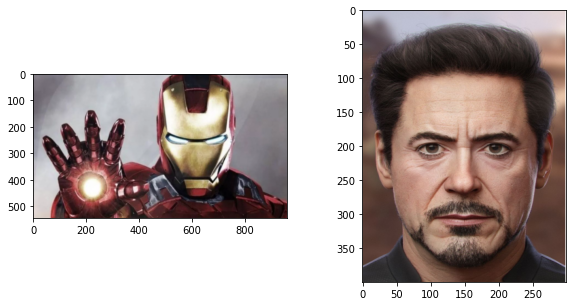

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from project2_util import *


def pyr_build(img):
    G0=img.astype(np.float32)
    lp=[]

    while G0.shape[0]>=32 and G0.shape[1]>=32:
        G1 = cv2.pyrDown(G0).astype(np.float32)
        G2 = cv2.pyrUp(G1,dstsize=[G0.shape[1],G0.shape[0]])
        L = G0.astype(np.float32) - G2.astype(np.float32)
        lp.append(L)
        # plt.imshow(L)
        # plt.figure()
        if  G1.shape[0]>=16 and G1.shape[1]>=16:
            G0 = G1
        else:
            break
    
    # plt.imshow(G0)
    lp.append(G0)
    return lp

def pyr_reconstruct(lp):
    R_current=lp[-1]

    for n in range(len(lp)-2,-1,-1):
        R_current=cv2.pyrUp(R_current,dstsize=[lp[n].shape[1],lp[n].shape[0]])+lp[n]
        R_current=np.clip(R_current, 0, 255).astype(np.uint8)

    recons_u8 = np.clip(R_current, 0, 255).astype(np.uint8)
    return recons_u8.astype(np.uint8)
        
def laplacian_blend(img1, img2, mask):
    """Create laplacian blend of img1 and img2, with mask blending them."""
    
    lp = []

    lpA = pyr_build(img1)
    lpB = pyr_build(img2)

    plt.imshowimg1_R=pyr_reconstruct(lpA)
    
    LP =[]
    for i in range(len(lpA)):
        h, w = lpA[i].shape[:2]
        mask_i = cv2.resize(mask, (w, h), interpolation=cv2.INTER_AREA)
        lp_i = alpha_blend(lpA[i], lpB[i], mask_i)
        LP.append(lp_i)
    result = pyr_reconstruct(LP)

    return result

# Credit - Image sources
# Image of TonyStark.jpg from 
# https://in.pinterest.com/pin/793196553103938467/
# Copyright Pinterest

# Image of Ironman suit
# henson.jpg
# converted to grayscale from 
# https://www.cnet.com/news/original-marvel-iron-man-suit-reportedly-missing-worth-320000/
# Copyright Marvel

# Image of Elon Musk 
# henson.jpg
# converted to grayscale from 
# https://www.linkedin.com/pulse/elon-musk-iron-man-narrative-analysis-teslas-ceos-personal-licheri/
# Copyright: Unsure



# #DEBUG    
# image0_path = '/work/example-images/apple.jpg'
# image1_path = '/work/example-images/orange.jpg'
# image2_path = '/work/example-images/split_mask.png'

# Actual implementation
image0_path = '/work/our_images/ironman.png'
image1_path = '/work/our_images/tonystark.png'
image2_path = '/work/example-images/split_mask.png'

iron_image = cv2.cvtColor(cv2.imread(image0_path), cv2.COLOR_BGR2RGB)
tony_image = cv2.resize(cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2RGB),(300,400), interpolation = cv2.INTER_AREA)
mask = cv2.cvtColor(cv2.imread(image2_path), cv2.IMREAD_GRAYSCALE)
mask2 = cv2.GaussianBlur(mask.copy(), (91, 91), 30.0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(iron_image, cmap='gray')
ax[1].imshow(tony_image, cmap='gray')



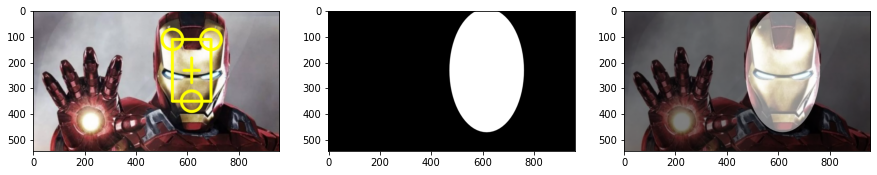

In [ ]:
# Build from points again
x0, y0 = 540, 110 # Top left
x1, y1 = 690, 110 # Top right
x2, y2 = 600, 350.320 # Center Bottom
iron_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))

ellipse_mask = ellipse_mask_from_roi(iron_image, iron_roi, wh_scales=(1.2, 2.0)) #1.9,3.3
display = draw_image_with_mask(iron_image, ellipse_mask)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(draw_roi_on_image(iron_image, iron_roi))
ax[1].imshow(ellipse_mask, cmap='gray')
ax[2].imshow(display)

# plt.imshow(laplacian_blend(tony_image,iron_image,ellipse_mask))



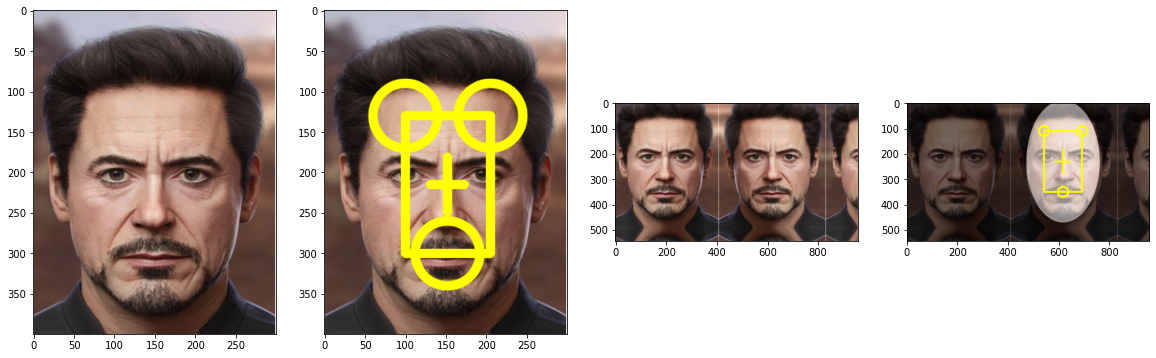

In [ ]:
# Getting Region of Interest in Tony's Image
# Build from points again
x0, y0 = 100, 130 # Top left
x1, y1 = 205, 130 # Top right
x2, y2 = 150, 300.320 # Center Bottom
tony_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))

tony_image_crop, tony_crop_roi = warp_helper_function(tony_image, iron_image, tony_roi, iron_roi, flip=True)

fig, ax = plt.subplots(1, 4, figsize=(5*4, 6))
ax[0].imshow(tony_image)
ax[1].imshow(draw_roi_on_image(tony_image, tony_roi))
ax[2].imshow(tony_image_crop)
ax[3].imshow(draw_roi_on_image(draw_image_with_mask(tony_image_crop, ellipse_mask), tony_crop_roi, thickness=5))

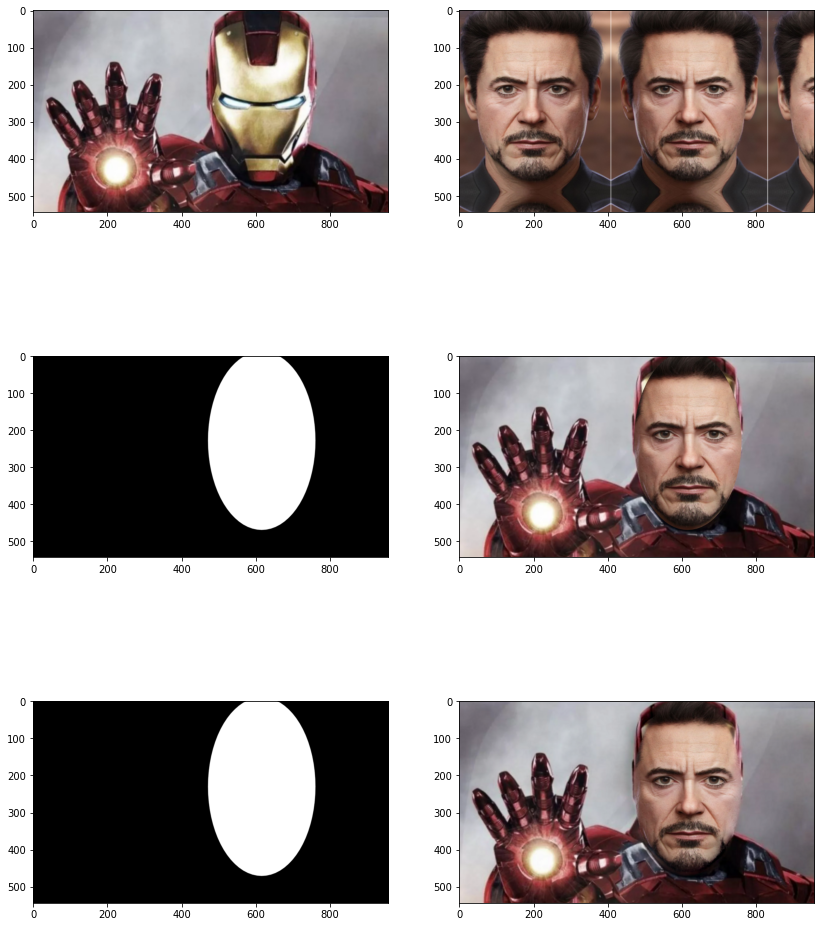

In [ ]:
# ellipse_mask2 = cv2.GaussianBlur(ellipse_mask.copy(), (31, 31), 7.0)
blend = alpha_blend(iron_image, tony_image_crop, ellipse_mask)
# blend2 = alpha_blend(iron_image, tony_image_crop, ellipse_mask2)
laplacian = laplacian_blend(iron_image,tony_image_crop,ellipse_mask)

fig, ax = plt.subplots(3,2,figsize=(2*7,3*6))
ax[0,0].imshow(iron_image)
ax[0,1].imshow(tony_image_crop)
ax[1,0].imshow(ellipse_mask, cmap='gray') # Grayscale colormap
ax[1,1].imshow(blend)
ax[2,0].imshow(ellipse_mask, cmap='gray') # Grayscale colormap
ax[2,1].imshow(laplacian)

## 3. Hybrid images

The image below is an example of an interesting optical illusion.

Up Close | Far Away
-----------------------|-----------------------
<p align="center"><img src="description-images/example2_hybrid.jpg" width="45%" /></p> | <p align="center"><img src="description-images/example2_hybrid.jpg" width="8%" /></p>

We went over the basic idea in class. When viewed close up, it appears to be
NASA mathematician Katherine Johnson. However if you view it from far
away (or use your browser's "zoom out" functionality to shrink it), it
begins to resemble actor Taraji P. Henson, who portrayed Johnson in
the film *Hidden Figures*.

Such a *hybrid image* can be obtained from two source images $A$
and $B$ by following these steps:

 * Obtain $A_{lopass} = g(A, \sigma_A)$ by blurring $A$ with a Gaussian
   kernel with width $\sigma_A$.
   
 * Obtain $B_{hipass} = B - g(B, \sigma_B)$ by blurring $B$ with a Gaussian kernel of width
   $\sigma_B$, and subtracting the result from $B$.
   
 * The resulting image is obtained as $I = A_{lopass} + k \, B_{hipass}$.
 
One important caveat is that hybrid images only work well if the two
input images $A$ and $B$ are well-aligned in the first place! You
simply won't get a good result if you try to make a hybrid image of a
skyscraper and a hot air balloon. I've also found that black-and-white 
images tend to work better than color but both can work fine if you 
choose your inputs carefully.

Also make sure that you convert your images to `numpy.float32` before
filtering/subtracting. Don't forget to to clip your final result to
the $[0, 255]$ intensity range before converting it to `numpy.uint8`
for display/output.

You will need to choose suitable constants $\sigma_A$, $\sigma_B$ and
$k$.  I suggest starting out with $\sigma_B$ to be a single-digit
number of pixels (assuming your input images are 100s of pixels tall),
choosing $\sigma_A = 2 \sigma_B$ and starting out with $k \approx 2.0$.

As a rule of thumb, if you want to see image $A$ more strongly, you
can *decrease* the $\sigma$ values and/or *decrease* $k$.  If you want to
see image $B$ more strongly, you can *increase* the $\sigma$ values and/or
*increase* $k$.

Complete this task by implementing **`hybrid_image`** and running it
on some input images that you provide. Save the output images in the project 
directory `output-images`


In [ ]:
def hybrid_image(img1, img2, sigmaA, sigmaB, k):
    """Create hybrid image of img1 and img2 using filter with parameters sigma and k (described above)"""
    # TODO: change this to correct implementation!
    img1_blur = cv2.GaussianBlur(img1, (sigmaA,sigmaA),cv2.BORDER_DEFAULT)
    img2_blur = cv2.GaussianBlur(img2, (sigmaB,sigmaB),cv2.BORDER_DEFAULT)
    result = img1_blur+ k*(img2 - img2_blur)
    recons_u8 = np.clip(result, 0, 255).astype(np.uint8)
    return recons_u8

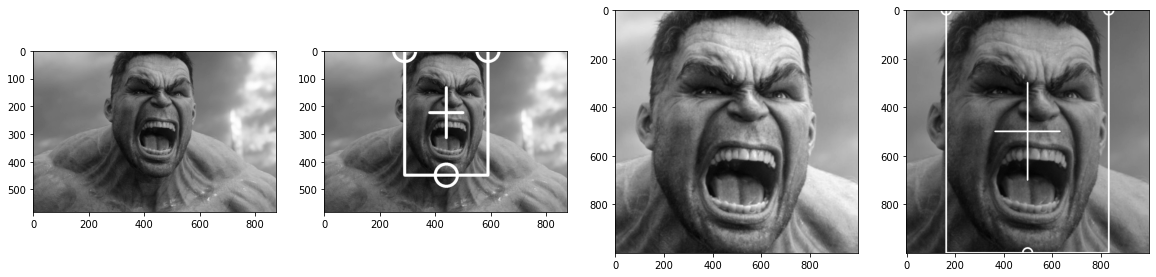

In [ ]:
hybrid0_path = '/work/our_images/hulk.png'
hybrid1_path = '/work/our_images/Avengers-4-Thanos.png'

thanos = (cv2.cvtColor(cv2.imread(hybrid1_path), cv2.COLOR_BGR2GRAY)).astype(np.float32)
hulk = cv2.resize((cv2.cvtColor(cv2.imread(hybrid0_path), cv2.COLOR_BGR2GRAY)),(thanos.shape[1],thanos.shape[0]), interpolation = cv2.INTER_AREA).astype(np.float32)

x0, y0 = 290, 1 # Top left
x1, y1 = 590, 1 # Top right
x2, y2 = 420, 450 # Center Bottom
hulk_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))

# Crop region of interest directly
hulk_crop_small, _ = crop_function(hulk, hulk_roi, 1000)
# Crop expanded version of region of interest, shifted slightly
hulk_crop, hulk_crop_roi = crop_function(hulk, hulk_roi, 1000, wh_scales=(1, 1), scroll_xy=(0, -1))

fig, ax = plt.subplots(1, 4, figsize=(5*4, 6))
ax[0].imshow(hulk, cmap='gray')
ax[1].imshow(draw_roi_on_image(hulk, hulk_roi), cmap='gray')
ax[2].imshow(hulk_crop_small, cmap='gray')
ax[3].imshow(draw_roi_on_image(hulk_crop, hulk_crop_roi, thickness=5), cmap='gray')



[array([[ 33.54663   , -50.260254  , -82.31067   , ...,  20.515625  ,
          53.02588   ,  40.529297  ],
        [ 75.370605  ,  -1.4345703 , -20.946533  , ...,  -0.52734375,
          41.617188  ,  44.33203   ],
        [ 52.361206  ,  22.319092  ,   2.3040771 , ...,  -8.135986  ,
          37.89801   ,  54.242676  ],
        ...,
        [-18.533203  , -17.789062  , -11.926758  , ...,  -9.760742  ,
          -6.433838  ,  19.341797  ],
        [ -7.758545  ,  -9.566895  , -14.287109  , ..., -12.848877  ,
         -15.040466  ,  14.229004  ],
        [ -4.166992  ,  -5.826172  , -10.407227  , ..., -23.544922  ,
         -28.242676  ,  -5.8085938 ]], dtype=float32),
 array([[  8.87207  , -48.411194 , -81.369064 , ..., -19.967827 ,
          -4.972748 ,  93.598526 ],
        [ 41.023712 ,  -0.783432 , -35.36847  , ..., -19.571487 ,
          -9.871689 ,  82.34204  ],
        [ 51.207016 ,  32.264755 ,   9.863464 , ..., -17.37294  ,
         -16.766327 ,  56.293945 ],
        ...,
   

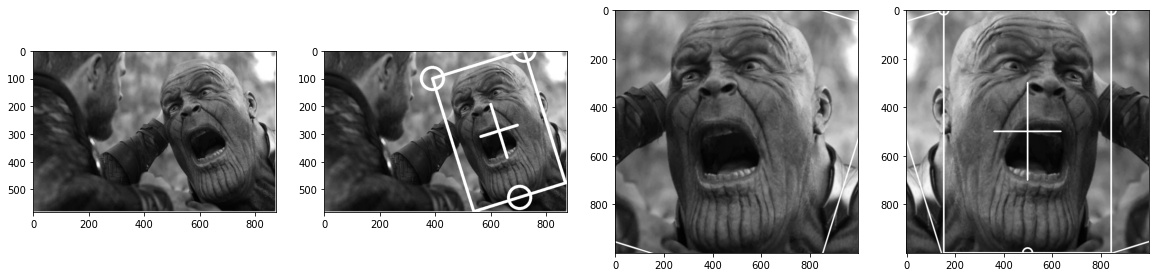

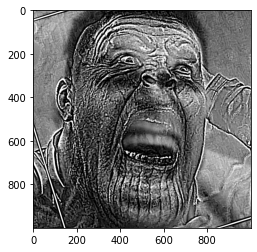

In [ ]:
# Getting Region of Interest in Thanos's image
# Build from points again
# x0, y0 = 450, 100 # Top left
# x1, y1 = 770, 100 # Top right
# x2, y2 = 150, 500.320 # Center Bottom
# thanos_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))

thanos_roi = ImageROI(**{
  "center": [
    630.1278305053711,
    290.84030675888062
  ],
  "angle": -0.3009266459941864,
  "width": 345.36065673828125,
  "height": 500.83647126793005
})


# Crop region of interest directly
thanos_crop_small, _ = crop_function(thanos, thanos_roi, 1000)
thanos_crop, thanos_crop_roi = warp_helper_function(thanos, hulk_crop, thanos_roi, hulk_crop_roi,flip=True)

fig, ax = plt.subplots(1, 4, figsize=(5*4, 6))
ax[0].imshow(thanos, cmap='gray')
ax[1].imshow(draw_roi_on_image(thanos, thanos_roi), cmap='gray')
ax[2].imshow(thanos_crop_small, cmap='gray')
ax[3].imshow(draw_roi_on_image(thanos_crop, thanos_crop_roi, thickness=5), cmap='gray')


plt.figure()
plt.imshow(hybrid_image(hulk_crop,thanos_crop,21,11,20),cmap='gray')

hybrid_img=hybrid_image(hulk_crop,thanos_crop,21,11,20)
pyr_build(hybrid_img)

In [ ]:
fauci_path = '/work/our_images/fauci.jpeg'
fauci = cv2.cvtColor(cv2.imread(fauci_path), cv2.COLOR_BGR2RGB)

x0, y0 = 350, 370 # Top left
x1, y1 = 470, 370 # Top right
x2, y2 = 390, 430 # Center Bottom
fauci_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))
# fig, ax = plt.subplots(1, 4, figsize=(5*4, 6))
fauci_lips = ellipse_mask_from_roi(fauci, fauci_roi,wh_scales=(1.7,1))
# fauci_crop_small, _ = crop_function(fauci, fauci_roi, 1000)
# ax[0].imshow(fauci)
# ax[1].imshow(draw_roi_on_image(fauci, fauci_roi))
# ax[2].imshow(fauci_lips)
# ax[3].imshow(fauci_crop_small)



video = cv2.VideoCapture('/work/our_images/extended.mov')
count = 0

x0, y0 = 500, 450 # Top left
x1, y1 = 620, 450 # Top right
x2, y2 = 560, 490 # Center Bottom
minh_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))

### for testing 
# minh_lips = ellipse_mask_from_roi(frame, minh_roi,wh_scales=(2.3,1.5))
# minh_crop_small, _ = crop_function(frame, minh_roi, 1000)
# ax[0].imshow(frame)
# ax[1].imshow(draw_roi_on_image(frame, minh_roi))
# ax[2].imshow(minh_lips)
# ax[3].imshow(minh_crop_small)

# Video writer
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter('Fauci_blend_video.mp4', fourcc, 30, (fauci.shape[1],fauci.shape[0]))

exist = 1
while exist:
    # read from video
    exist, frame = video.read()
    if not exist:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

    #get mask from video
    minh_roi = roi_from_points((x0, y0), (x1, y1), (x2, y2))
    minh_lips = ellipse_mask_from_roi(frame, minh_roi,wh_scales=(2.3,1.5))

    # wrap the frame and fauci image
    vid_crop, vid_crop_roi = warp_helper_function(frame, fauci, minh_roi, fauci_roi)
    vid_mask = ellipse_mask_from_roi(fauci, vid_crop_roi,wh_scales=(1.7,1))
    ellipse_mask_vid = cv2.GaussianBlur(vid_mask.copy(), (25,25), 7.0)

    # laplacian blend and output to video
    new_frame = laplacian_blend(fauci,vid_crop,ellipse_mask_vid)
    writer.write(cv2.cvtColor(new_frame,cv2.COLOR_BGR2RGB))
    count += 1


writer.release() 







## 4. Write up

Please address the following questions/items below in markdown blocks in this notebook. Note that it should be equivalent to 3-6 pages in a PDF:

  * Who did what for this project?
 
  * How did you obtain and align your images for each of the two
    tasks?

  * Include representative Laplacian pyramid blending outputs in your
    PDF.

  * Why does Laplacian pyramid blending blend low-frequency content
    over a larger distance than high-frequency content? See if you can
    illustrate this with some carefully chosen input image examples.
    
  * Include your hybrid image output in your report. 
  
  * How did you arrive at good values for the constants $\sigma_A$,
    $\sigma_B$, and $k$ for the hybrid image generation?
    Describe the process.

  * If you display your hybrid image at full size on your computer
    screen, how close do you need to be in order to primarly see image
    $B$? How far away do you need to get before you only see features
    from image $A$? Are these distances fairly consistent between you,
    your project partner, and/or any unsuspecting friends you show
    your image to?

  * Generate a Laplacian pyramid of your hybrid image and include it
    in your report. To what extent does each pyramid level
    resemble image $A$ or image $B$, and why?

## 5. Evaluation Criterion

Your project will be evaluated by the following criteria (percentages
are approximate):

  * **source code, raw data, and output (25%)** - Turn in the full
    source code for your project, including any additional files
    needed to run it.  You should also submit the program inputs and
    outputs as image files.  I expect your code to be neatly indented
    and reasonably commented.  Please expect to spend plenty of time
    photographing/obtaining and aligning suitable input images for
    both main tasks above -- it is critical to have reasonably well
    aligned inputs, especially for the second task!

  * **Laplacian pyramid results (20%)** - The results of your
    Laplacian pyramid blending should be free of sharp seams, and be
    clearly superior to traditional alpha blending.

  * **hybrid image results (20%)** - Your image should clearly
    transition from image $A$ to image $B$ as the viewer approaches
    from far away.

  * **going further (10%)** - Go above and beyond the tasks outlined
    above. Examples might include writing additional helper programs to align
    input images and/or generate masks; adapting either one of the
    above techniques to work on video;
    visualizing intermediate computations/results of the above tasks;
    researching and discussing other uses of pyramid representations
    in computer vision, etc. Feel free to ask if you want to run any
    ideas by me!

  * **written report (25%)** - Your report should address all of
    the questions/items mentioned above, and contain the relevant
    images as figures.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0bf9a5ad-e55f-48e2-82a9-70f553b074de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>